# Notebook for Project


In [2]:
import pandas as pd

df_= pd.read_csv('data/churn.csv')

df_ =df_.drop(columns=["RowNumber","CustomerId","Surname"])

In [3]:
df_.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


<Axes: xlabel='Age', ylabel='NumOfProducts'>

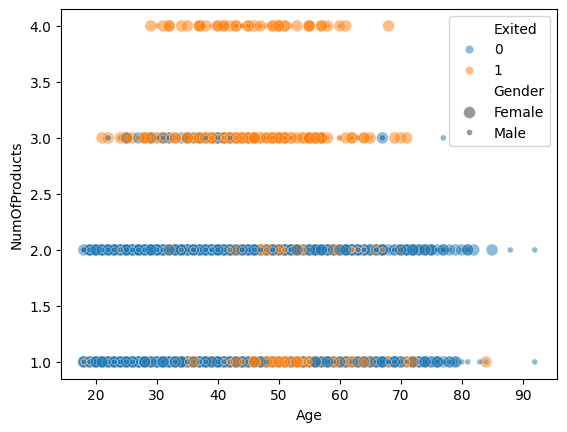

In [5]:
import seaborn as sns

sns.scatterplot(data=df_, x="Age", y="NumOfProducts", hue="Exited", size = "Gender", alpha=0.5)


2026/01/28 14:33:34 INFO mlflow.tracking.fluent: Experiment with name 'Test_Churn' does not exist. Creating a new experiment.
2026/01/28 14:33:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lionel/DEVIA/MLFL/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/28 14:33

Accuracy: 0.7626622017580578
Classification Report:
               precision    recall  f1-score   support

           0     0.7734    0.7640    0.7687      1233
           1     0.7515    0.7612    0.7563      1156

    accuracy                         0.7627      2389
   macro avg     0.7624    0.7626    0.7625      2389
weighted avg     0.7628    0.7627    0.7627      2389



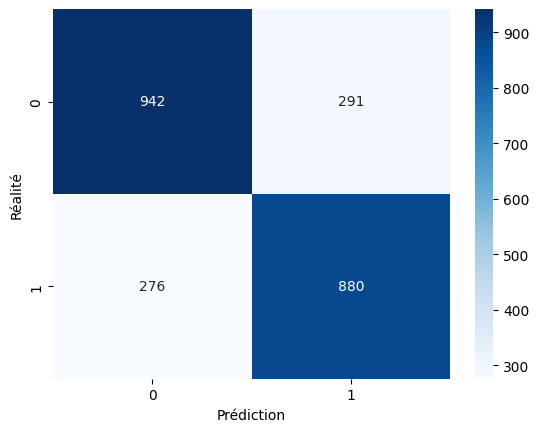

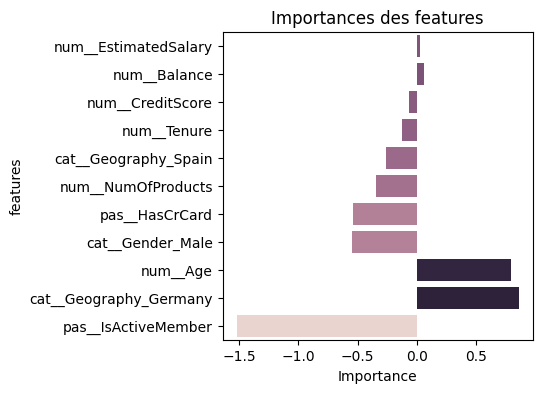

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, log_loss, accuracy_score
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mlflow

# préparation des données
X = df_.drop(columns=["Exited"])
y = df_["Exited"]

# Séparation par type de transformations
num_features = ["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary"]
cat_features = ["Geography","Gender"]
pas_features = ["HasCrCard","IsActiveMember"]

# On resample les donnée pour équilibrer les résultats.
smote = SMOTENC(random_state=42,categorical_features=["Geography","Gender"])
X_resampled, y_resampled = smote.fit_resample(X, y)

#Création du preprocessor pour préparation des données
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop='first'), cat_features),
        ("pas", "passthrough", pas_features)
    ]
)

mlflow.set_experiment("Test_Churn")

# MLflow tracking
with mlflow.start_run(run_name="Logistic_Regression_Churn"):
    
    model = LogisticRegression(max_iter=1000, C=0.01)

    # Création du pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ]
    )

    # Division Dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42)

    # Fit du model 
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

# Evaluation du model 
accscore = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
rocaucscore = roc_auc_score(y_test, y_pred)
loglossscore = log_loss(y_test, y_pred)
prescore = precision_score(y_test, y_pred)
recscore = recall_score(y_test, y_pred)
print("Accuracy:", accscore)
print("F1 Score:", f1score)
print("ROC AUC Score:", rocaucscore)
print("Log Loss:", loglossscore)
print("Precision:", prescore)
print("Recall:", recscore)
metrics = {
    "accuracy": accscore,
    "f1_score": f1score,
    "roc_auc": rocaucscore,
    "log_loss": loglossscore,
    "precision": prescore,
    "recall": recscore
}
mlflow.log_metrics

# 14. Sauvegarder le modèle
models_storage = {
    "model": pipeline,
    "features" : X_resampled.columns.tolist(),
    "metrics": metrics
}



## Random Forrest 200

2026/01/28 14:40:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lionel/DEVIA/MLFL/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/28 14:40:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lionel/DEVIA/MLFL/.venv/lib/pytho

Accuracy: 0.8476349937212223
Classification Report:
               precision    recall  f1-score   support

           0     0.8559    0.8475    0.8517      1233
           1     0.8390    0.8478    0.8434      1156

    accuracy                         0.8476      2389
   macro avg     0.8474    0.8476    0.8475      2389
weighted avg     0.8477    0.8476    0.8477      2389



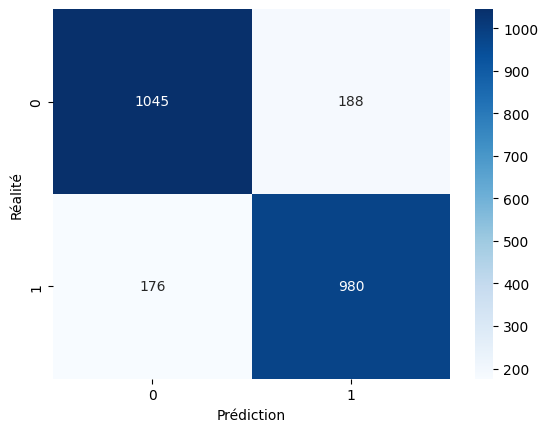

AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# MLflow tracking
with mlflow.start_run(run_name="Random_Forest_Churn"):
    
    model = RandomForestClassifier(n_estimators=200, criterion='gini')

    # Création du pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ]
    )

    # Division Dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42)

    # Fit du model 
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

# Evaluation du model 
accscore = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
rocaucscore = roc_auc_score(y_test, y_pred)
loglossscore = log_loss(y_test, y_pred)
prescore = precision_score(y_test, y_pred)
recscore = recall_score(y_test, y_pred)
print("Accuracy:", accscore)
print("F1 Score:", f1score)
print("ROC AUC Score:", rocaucscore)
print("Log Loss:", loglossscore)
print("Precision:", prescore)
print("Recall:", recscore)
metrics = {
    "accuracy": accscore,
    "f1_score": f1score,
    "roc_auc": rocaucscore,
    "log_loss": loglossscore,
    "precision": prescore,
    "recall": recscore
}
mlflow.log_metrics

# 14. Sauvegarder le modèle
models_storage = {
    "model": pipeline,
    "features" : X_resampled.columns.tolist(),
    "metrics": metrics
}



## XGBoost

2026/01/28 14:50:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lionel/DEVIA/MLFL/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/28 14:50:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lionel/DEVIA/MLFL/.venv/lib/pytho

Accuracy: 0.8367517789870239
Classification Report:
               precision    recall  f1-score   support

           0     0.8430    0.8402    0.8416      1233
           1     0.8302    0.8330    0.8316      1156

    accuracy                         0.8368      2389
   macro avg     0.8366    0.8366    0.8366      2389
weighted avg     0.8368    0.8368    0.8368      2389



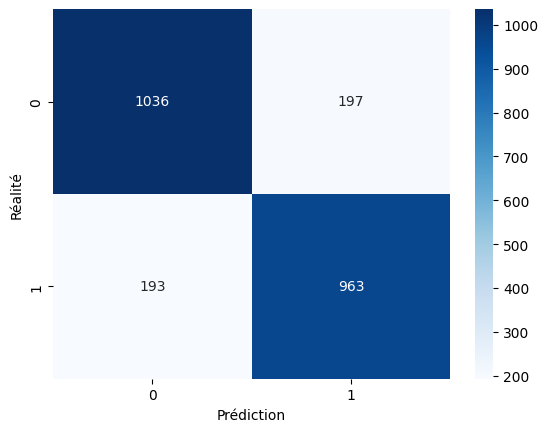

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
# MLflow tracking
with mlflow.start_run(run_name="XGBoost_Churn"):
    
    model = xgb.XGBClassifier(
        n_estimators=200, 
        max_depth=3,
        learning_rate=0.1)

    # Création du pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ]
    )

    # Division Dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42)

    # Fit du model 
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

# Evaluation du model 
accscore = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
rocaucscore = roc_auc_score(y_test, y_pred)
loglossscore = log_loss(y_test, y_pred)
prescore = precision_score(y_test, y_pred)
recscore = recall_score(y_test, y_pred)
print("Accuracy:", accscore)
print("F1 Score:", f1score)
print("ROC AUC Score:", rocaucscore)
print("Log Loss:", loglossscore)
print("Precision:", prescore)
print("Recall:", recscore)
metrics = {
    "accuracy": accscore,
    "f1_score": f1score,
    "roc_auc": rocaucscore,
    "log_loss": loglossscore,
    "precision": prescore,
    "recall": recscore
}
mlflow.log_metrics

# 14. Sauvegarder le modèle
models_storage = {
    "model": pipeline,
    "features" : X_resampled.columns.tolist(),
    "metrics": metrics
}



In [10]:
y_pred = pipeline.predict(X_train)
print("Classification Report:\n", classification_report(y_train, y_pred, digits=4))

2026/01/28 14:59:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lionel/DEVIA/MLFL/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Classification Report:
               precision    recall  f1-score   support

           0     0.8494    0.8565    0.8529      6730
           1     0.8569    0.8499    0.8534      6807

    accuracy                         0.8531     13537
   macro avg     0.8532    0.8532    0.8531     13537
weighted avg     0.8532    0.8531    0.8531     13537

